参考文章：[TensorFlow - Classify text with BERT](https://tensorflow.google.cn/text/tutorials/classify_text_with_bert), [TensorFlow - Solve GLUE tasks using BERT on TPU](https://tensorflow.google.cn/text/tutorials/bert_glue?_gl=1*gyizha*_ga*MzE5NzQ4ODU5LjE2Njg5MzczMDE.*_ga_W0YLR4190T*MTY3MDgzNTEwMC4xOC4xLjE2NzA4MzUxMDMuMC4wLjA.)

In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, losses, optimizers, metrics
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

encoder_handle = r'model/bert_encoder/'
preprocesser_handle = r'model/bert_preprocessor/'
val_split = 25  # 验证集的占比
seed = 109

## 数据预处理

训练集：[online_shopping_10_cats](https://github.com/SophonPlus/ChineseNlpCorpus/blob/master/datasets/online_shopping_10_cats/intro.ipynb).

1. 数据筛选.
2. 平均训练数据.
3. 数据预载入.

数据的格式为，特征：评论文本；标签：(情感类别，商品类别)


In [3]:
df = pd.read_csv(r'./dataset/online_shopping_10_cats.csv')
df

,cat,label,review
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...
...,...,...,...
62769,酒店,0,我们去盐城的时候那里的最低气温只有4度，晚上冷得要死，居然还不开空调，投诉到酒店客房部，得到...
62770,酒店,0,房间很小，整体设施老化，和四星的差距很大。毛巾太破旧了。早餐很简陋。房间隔音很差，隔两间房间...
62771,酒店,0,我感觉不行。。。性价比很差。不知道是银川都这样还是怎么的！
62772,酒店,0,房间时间长，进去有点异味！服务员是不是不够用啊！我在一楼找了半个小时以上才找到自己房间，想找...


In [4]:
# 删去Nan项
df = df[df.review.isna() == False]

In [5]:
print('评论总数：', df.shape[0])
print('正向评论：', df[df.label==1].shape[0])
print('负向评论：', df[df.label==0].shape[0])

评论总数： 62773
正向评论： 31727
负向评论： 31046


In [6]:
class_names = list(df.cat.drop_duplicates())

In [7]:
info_df = pd.DataFrame(columns=['类别', '总数目', '正例', '负例'])
class2idx = {}
idx2class = {}
for idx, name in enumerate(class_names):
    tmp = df[df.cat==name]
    info_df.loc[info_df.shape[0]] = [name, tmp.shape[0], tmp[tmp.label==1].shape[0], tmp[tmp.label==0].shape[0]]
    class2idx[name] = idx
    idx2class[idx] = name
info_df

,类别,总数目,正例,负例
0,书籍,3851,2100,1751
1,平板,10000,5000,5000
2,手机,2323,1165,1158
3,水果,10000,5000,5000
4,洗发水,10000,5000,5000
5,热水器,574,474,100
6,蒙牛,2033,992,1041
7,衣服,10000,5000,5000
8,计算机,3992,1996,1996
9,酒店,10000,5000,5000


In [8]:
target = 10
ds = tf.data.Dataset.from_tensor_slices(([1,2], [(1,2),(3,4)]))
ds.take(15)
ds.skip(5)
list(ds.as_numpy_iterator())

[(1, array([1, 2])), (2, array([3, 4]))]

In [9]:
ds = tf.data.Dataset.from_tensor_slices(range(10)).batch(2)
list(ds.take(2).as_numpy_iterator())

[array([0, 1]), array([2, 3])]

In [10]:
# 首先将每种类别商品的数据按照3:1划分为训练集和验证集，然后对训练集进行补全到7500个数据
train_ds, val_ds = None, None
for name in class_names:
    tmp = df[df.cat==name]
    pos_num, neg_num = tmp[tmp.label==1].shape[0], tmp[tmp.label==0].shape[0]
    pos_ds = tf.data.Dataset.from_tensor_slices((tmp[tmp.label==1]['review'], [(1, class2idx[name]) for _ in range(pos_num)]))
    neg_ds = tf.data.Dataset.from_tensor_slices((tmp[tmp.label==0]['review'], [(0, class2idx[name]) for _ in range(neg_num)]))
    
    pos_num = pos_num * val_split // 100
    neg_num = neg_num * val_split // 100
    pos_val = pos_ds.take(pos_num)
    pos_train = pos_ds.skip(pos_num)
    neg_val = neg_ds.take(neg_num)
    neg_train = neg_ds.skip(neg_num)
    
    train_marge = pos_train.concatenate(neg_train).shuffle(10000, seed=seed).repeat(-1)  # 合并正负数据，再补齐到7500个数据
    train_ds = train_marge.take(7500) if train_ds is None else train_ds.concatenate(train_marge.take(7500))
    val_ds = pos_val.concatenate(neg_val) if val_ds is None else val_ds.concatenate(pos_val).concatenate(neg_val)
    
    print(f"加入后'{name}'：训练集大小{train_ds.cardinality()}，验证集大小{val_ds.cardinality()}")

加入后'书籍'：训练集大小7500，验证集大小962
加入后'平板'：训练集大小15000，验证集大小3462
加入后'手机'：训练集大小22500，验证集大小4042
加入后'水果'：训练集大小30000，验证集大小6542
加入后'洗发水'：训练集大小37500，验证集大小9042
加入后'热水器'：训练集大小45000，验证集大小9185
加入后'蒙牛'：训练集大小52500，验证集大小9693
加入后'衣服'：训练集大小60000，验证集大小12193
加入后'计算机'：训练集大小67500，验证集大小13191
加入后'酒店'：训练集大小75000，验证集大小15691


In [11]:
# 根据数据集中句子的长度来确定256个输入长度是合理的
df_len = df['review'].apply(lambda x: len(x))
print(df_len.shape)
print(np.sum(df_len<=254))
print(np.percentile(df_len, 98))
df_len.describe()

(62773,)
61430
263.0


count    62773.000000
mean        58.414892
std         78.748469
min          1.000000
25%         21.000000
50%         34.000000
75%         64.000000
max       2876.000000
Name: review, dtype: float64

## 模型预处理

In [12]:
# ds = tf.data.Dataset.from_tensor_slices((data_x, data_y))

### Preprocess预处理结果
对于输入字符串 `你好`，预处理会在字符串开头和结尾处加上开始符号和停止符号，变为 `[CLS]你好[SEP]`，在原有序列长度上增加2.

1. `input_mask`：一个one-hot向量，1表示有字，0表示没有字.
2. `input_word_ids`：将每个字进行编码，101表示`[CLS]`，102表示`[SEP]`.
3. `input_type_ids`：只有在两句话作为输入特征时才有作用，用于划分两句话.

### Bert输出结果
1. `pooled_output`：输入的句子向量. `[bath_size, 768]`.
2. `sequence_output`：最后一个transform的输出结果. `[batch_size, 128, 768]`.
3. `encoder_outputs`：长度为12的list，对应12个transform的输出结果. `[12, batch_size, 128, 768]`.

### 建立预处理模型

In [13]:
# 自定义预处理模型
# preprocessor = hub.KerasLayer(r'model/bert_zh_preprocess_3/')
def bert_preprocessor(sentence_features, seq_length=128):
    text_inputs = [layers.Input(shape=(), dtype=tf.string, name=ft)
                   for ft in sentence_features]  # 处理输入的句子特征
    
    preprocessor = hub.load(preprocesser_handle)
    tokenize = hub.KerasLayer(preprocessor.tokenize, name='tokenizer')
    tokenized_inputs = [tokenize(segment) for segment in text_inputs]  # 将句子划分为字
    
    packer = hub.KerasLayer(
        preprocessor.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name='packer'
    )
    encoder_inputs = packer(tokenized_inputs)
    return keras.Model(text_inputs, encoder_inputs, name='preprocessor')
preprocessor = bert_preprocessor(['input1'])

In [14]:
x = tf.constant(['你好呀', '不好但是'])
x_preprocessed = preprocessor(x)
print(f"{'Keys':<15}: {list(x_preprocessed.keys())}")
print(f"{'Shape Word Ids':<15}: {x_preprocessed['input_word_ids'].shape}")
print(f"{'Word Ids':<15}: {x_preprocessed['input_word_ids'][0,:12]}")
print(f"{'Shape Mask':<15}: {x_preprocessed['input_mask'].shape}")
print(f"{'Input Mask':<15}: {x_preprocessed['input_mask'][0,:12]}")
print(f"{'Shape Type Ids':<15}: {x_preprocessed['input_type_ids'].shape}")
print(f"{'Type Ids':<15}: {x_preprocessed['input_type_ids'][0,:12]}")

Keys           : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape Word Ids : (2, 128)
Word Ids       : [ 101  872 1962 1435  102    0    0    0    0    0    0    0]
Shape Mask     : (2, 128)
Input Mask     : [1 1 1 1 1 0 0 0 0 0 0 0]
Shape Type Ids : (2, 128)
Type Ids       : [0 0 0 0 0 0 0 0 0 0 0 0]


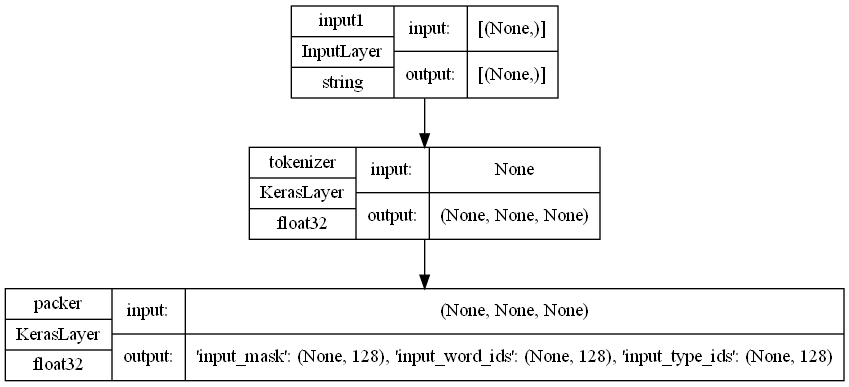

In [15]:
keras.utils.plot_model(preprocessor, show_shapes=True, show_dtype=True, to_file='Preprocessor.png')

### 建立bert模型

In [16]:
bert_model = hub.KerasLayer(encoder_handle)

In [17]:
# 一个两个输入句子的例子
# x = [tf.constant(['国破山河在']), tf.constant(['城春草木深'])]
# 句子转为向量
text = tf.constant(['国破山河在'])
text_preprocessed = preprocessor(text)
bert_results = bert_model(text_preprocessed)
print(bert_results.keys())
bert_results['pooled_output'][0].numpy().shape

dict_keys(['pooled_output', 'default', 'sequence_output', 'encoder_outputs'])


(768,)

In [18]:
def build_classifier():
    class Classifier(keras.Model):
        def __init__(self):
            super().__init__(name='prediction')
            self.encoder = hub.KerasLayer(encoder_handle, trainable=True)
            # self.dense = layers.Dense(768, activation='relu')
            self.dropout = layers.Dropout(0.3)
            self.emotion = layers.Dense(1)  # 情感分类
            self.classifier = layers.Dense(10)  # 文本分类
            
        def call(self, text):  # 经过预处理后的文本
            output = self.encoder(text)
            pooled_output = output['pooled_output']
            x = self.dropout(pooled_output)
            x1 = self.emotion(x)
            x2 = self.classifier(x)
            return (x1, x2)
    
    model = Classifier()
    return model

# model = build_classifier()
# model.build(input_shape=())

In [19]:
def build_classifier():
    text_input = layers.Input(shape=(), dtype=tf.string, name='input')
    text_preprocessed = preprocessor(text_input)
    encoder = hub.KerasLayer(encoder_handle, trainable=True, name='BERT_encoder')
    x = encoder(text_preprocessed)['pooled_output']
    x = layers.Dropout(0.3)(x)
    x1 = layers.Dense(1, name='emotion')(x)
    x2 = layers.Dense(10, name='classifier')(x)
    return keras.Model(text_input, [x1, x2])
classifier_model = build_classifier()

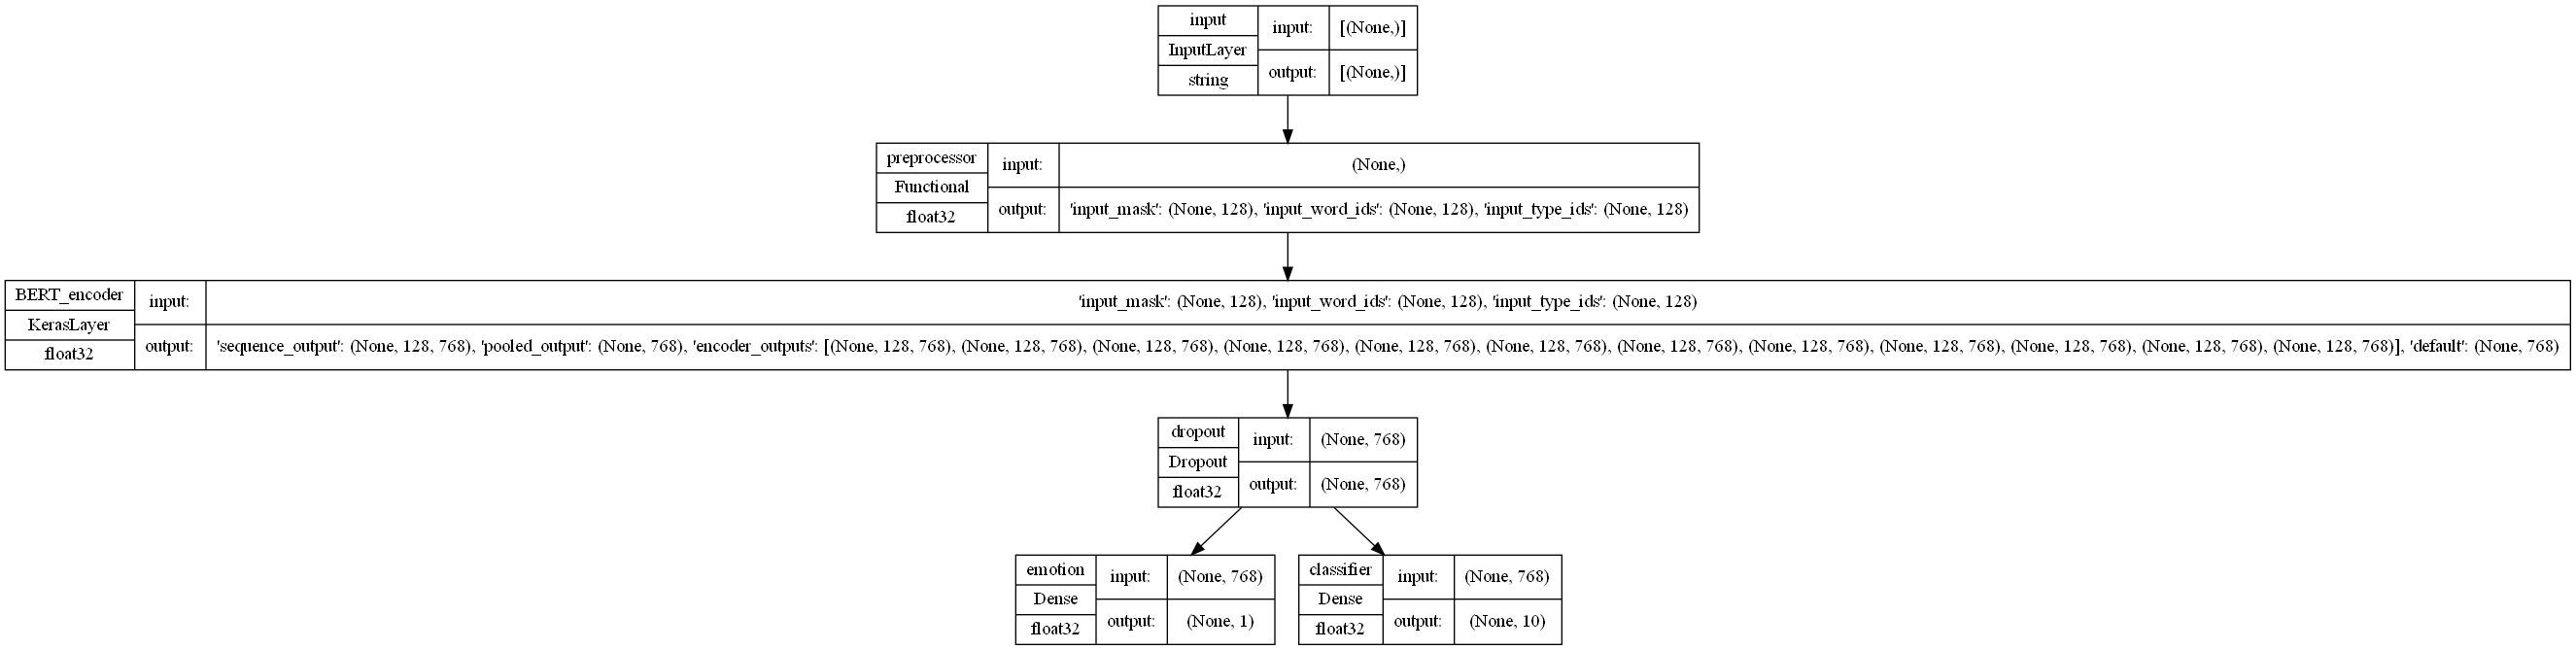

In [20]:
keras.utils.plot_model(classifier_model, show_dtype=True, show_shapes=True)

In [21]:
# 测试输出
classifier_model(text)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.2013735]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-2.2343225 ,  0.34765464,  0.5692795 , -0.40534532,  0.05779657,
         -1.6899788 ,  1.8460698 ,  3.082738  , -1.2819345 , -0.4283673 ]],
       dtype=float32)>]

In [22]:
# 超参数配置
batch_size = 16
batch_N = 100000 / 32
epochs = 10
optimizer = optimizers.Adam(learning_rate=1e-4)  # Adam优化器，设定步长
binary_loss = losses.BinaryCrossentropy(from_logits=True)  # 情感分类使用二元交叉熵
multi_loss = losses.SparseCategoricalCrossentropy(from_logits=True)  # 物品分类使用一般的交叉熵
train_ds = train_ds.shuffle(100000).batch(batch_size).repeat(epochs)  # 随机打乱样本，设定batch大小
val_ds = val_ds.batch(batch_size)
# 计数器
emotion_acc = keras.metrics.BinaryAccuracy('emotion_acc')  # 情感分类上的准确率
emotion_loss= keras.metrics.Mean('emotion_loss', dtype=tf.float32)  # 情感分类的平均损失
class_acc = keras.metrics.SparseCategoricalAccuracy('class_acc')  # 物品分类上的准确率
class_loss = keras.metrics.Mean('class_loss', dtype=tf.float32)  # 物品分类上的平均损失
metrics = [emotion_acc, emotion_loss, class_acc, class_loss]

In [23]:
x, y = next(train_ds.as_numpy_iterator())
x_preprocessed = preprocessor(x)
len(x_preprocessed['input_word_ids'][0])

128

In [ ]:
history = dict()
print("Start training!!!")
def test(val_ds):  # 模型测试
    for (x, y) in val_ds:
        emotion_y = tf.reshape(y[:, 0], [-1, 1])  # 情感标签
        classes_y = tf.reshape(y[:, 1], [-1, 1])  # 分类标签
        emotion, classes = classifier_model(x, training=False)
        emotion_acc.update_state(emotion_y, emotion)
        class_acc.update_state(classes_y, classes)
        break

def train():  # 模型训练
    for step, (x, y) in enumerate(train_ds):
        emotion_y = tf.reshape(y[:, 0], [-1, 1])  # 情感标签
        classes_y = tf.reshape(y[:, 1], [-1, 1])  # 分类标签
        with tf.GradientTape() as tape:
            emotion, classes = classifier_model(x, training=True)  # 模型预测
            loss1 = binary_loss(emotion_y, emotion)  # y=(batch, 2)
            loss2 = multi_loss(classes_y, classes)
            loss = tf.reduce_mean(loss1 + loss2)  # 将两个loss求和作为总损失
        grads = tape.gradient(loss, classifier_model.trainable_variables)  # 求梯度
        optimizer.apply_gradients(zip(grads, classifier_model.trainable_variables))  # 更新网络参数

        emotion_acc.update_state(emotion_y, emotion)
        emotion_loss.update_state(loss1)
        class_acc.update_state(classes_y, classes)
        class_loss.update_state(loss2)

        if step % 100 == 0:
            s = f"step={step}/{batch_N * epochs}: "
            for metric in metrics:
                s += f"{metric.name}={metric.result().numpy():.3f} "
                if metric.name not in history.keys():
                    history[metric.name] = []
                history[metric.name].append(metric.result().numpy())
                metric.reset_states()
            print(s)
            test(val_ds)  # 求验证集上的准确率
            s = ""
            for metric in metrics:
                s += f"{'val_'+metric.name}={metric.result().numpy():.3f} "
                if 'val_' + metric.name not in history.keys():
                    history['val_'+metric.name] = []
                history['val_'+metric.name].append(metric.result().numpy())
                metric.reset_states()
            print(s)
        break
train()
print("OK")

Start training!!!
